In [11]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [12]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel

import numpy as np
import pandas as pd

In [13]:
training_folder = '../../'

In [14]:
sm = stepmodel.read_zippedpickles(training_folder + 'model/{scen}/aon_pathfinder'.format(scen=scenario))

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 28.48it/s]


# generation
- Production = Population
- Attraction = Jobs

In [15]:
sm.zones['emission'] =  sm.zones['pop'].astype(int) / 10 # peak hour generation
sm.zones['attraction'] =  sm.zones['emp'].astype(int) / 10
sm.zones['pop'].sum()

2158238.2271273527

# car owners
car owners distribution is based on car times

In [16]:
motor_rate = 0.3
car = sm.copy()
car.zones['emission'] *= motor_rate

In [17]:
imp_matrix = car.car_los[
    ['origin', 'destination', 'time']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

car.step_distribution(deterrence_matrix=imp_matrix)

# PT captives
car owners distribution is based on car times

In [18]:
pt = sm.copy()
pt.zones['emission'] *= (1-motor_rate)

In [19]:
# Ici on prend comme fonction de coût le temps TC. Notez le .unstack() 
imp_matrix = pt.pt_los[
    ['origin', 'destination', 'gtime']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

In [20]:
pt.step_distribution(deterrence_matrix=imp_matrix)

In [21]:
pt.volumes

,origin,destination,volume
0,zone_0,zone_0,0.007953
1,zone_0,zone_1,0.431277
2,zone_0,zone_2,0.300946
3,zone_0,zone_3,0.410764
4,zone_0,zone_4,0.397187
...,...,...,...
12095,zone_109,zone_105,1.770855
12096,zone_109,zone_106,6.871817
12097,zone_109,zone_107,4.593120
12098,zone_109,zone_108,4.165678


# merge matrices

In [22]:
sm.volumes = pd.merge(
    car.volumes,
    pt.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
).rename(columns={'volume_car_owner': 'car_owner', 'volume_pt_captive': 'pt_captive'})

# to_zip

In [23]:
sm.to_zippedpickles(
    training_folder + 'model/{scen}/distribution'.format(scen=scenario), 
    only_attributes=['volumes', 'epsg', 'coordinates_unit']
)

volumes: 100%|████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 680.78it/s]


# monitoring

Text(0.5, 1.0, 'PT captives distribution')

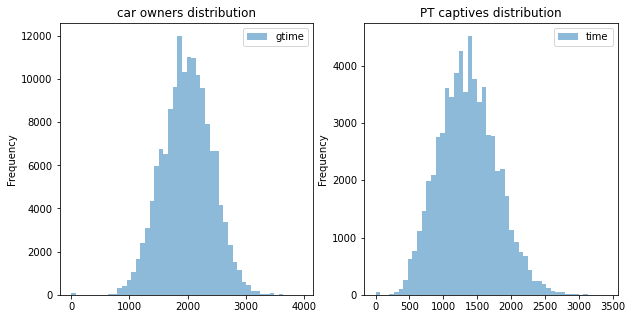

In [24]:
od = pd.merge(sm.volumes, sm.pt_los, on=['origin', 'destination'])
od = pd.merge(od, sm.car_los, on=['origin', 'destination'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=[10, 5])
plot = od[['gtime']].plot(kind='hist', weights=od['pt_captive'], bins=50, alpha=0.5, ax=axes[0])
plot.set_title('car owners distribution')
plot = od[['time']].plot(kind='hist', weights=od['car_owner'], bins=50, alpha=0.5, ax=axes[1])
plot.set_title('PT captives distribution')

# END